In [1]:
from torch_geometric.datasets import MoleculeNet
import seaborn as sns
import numpy as np
import pandas as pd
from IPython.display import clear_output
from scipy.spatial import cKDTree
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch.utils.data import Dataset, DataLoader 
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import torch.nn as nn
import torch_geometric.nn as geom_nn
import copy
from torch.optim.lr_scheduler import  ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
import pickle
import math

import torch
from torch.nn import Linear
import torch.nn.functional as F 
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.nn.dense import DenseGCNConv

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Matplotlib created a temporary cache directory at /localscratch-ssd/290371/matplotlib-ie8mnz3i because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [47]:
### Load the list from the pickle file ###
### Train Data ###
with open('train_data_np_scaled.pkl', 'rb') as f:
    train_data_np_scaled = pickle.load(f)

### Test Data ###
with open('test_data_np_scaled.pkl', 'rb') as f:
    test_data_np_scaled = pickle.load(f)

# Combined_model

In [2]:
def make_batch_index_tensor(node_length, batch_size):
    # Create a tensor containing values from 0 to batch_size - 1
    values = torch.arange(batch_size)
    # Repeat each value node_length times and flatten the result
    repeated_values = values.repeat_interleave(node_length)
    return repeated_values

In [3]:
def make_edge_index_tensor(batch_size):
    
    edge_index = torch.tensor([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                               [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]])
    
    if batch_size==1:
    
        return edge_index
    
    if batch_size>1:
        
        add = torch.cat([ torch.tensor([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]]) + 16*(i+1) for i in range(batch_size-1)],axis=1)
        
        edge_index_expanded = torch.cat((edge_index,add),axis=1)
    
        return edge_index_expanded

In [34]:
from torch_geometric.nn import GATv2Conv, global_add_pool as gap

gatv2conv = GATv2Conv(in_channels=4, out_channels=64, num_heads=5)

edge_index = torch.tensor([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                               [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]])
    
trial_input = torch.randn(16,4)

gatv2conv(trial_input,edge_index).shape

torch.Size([16, 64])

In [79]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv, global_add_pool as gap

class GNN_with_attention(nn.Module):
    
    def __init__(self, num_gcn_layers=2, num_fcnn_layers=2, gcn_embedding_size=64, fcnn_embedding_size=64,
                 num_nodes=16, num_features=4, dropout_prob=0.5, heads=2):
        
        super(GNN_with_attention, self).__init__()
        torch.manual_seed(42)

        self.num_gcn_layers = num_gcn_layers
        self.num_fcnn_layers = num_fcnn_layers
        self.gcn_embedding_size = gcn_embedding_size
        self.fcnn_embedding_size = fcnn_embedding_size
        self.num_nodes = num_nodes
        self.num_features = num_features
        self.heads = heads
        self.dropout_prob = dropout_prob

        self.initial_conv = GATv2Conv(self.num_features, self.gcn_embedding_size, self.heads)
        
        self.convs = nn.ModuleList([GATv2Conv(self.gcn_embedding_size * self.heads, self.gcn_embedding_size, self.heads) 
                                    for _ in range(self.num_gcn_layers - 1)])
        
#         self.fcnn_layers = nn.ModuleList([nn.Linear(self.gcn_embedding_size * self.heads + 4, self.fcnn_embedding_size)] +
#                                          [nn.Linear(self.fcnn_embedding_size, self.fcnn_embedding_size) for _ in range(self.num_fcnn_layers - 2)] +
#                                          [nn.Linear(self.fcnn_embedding_size, 1)])
        
        self.dropout = nn.Dropout(p=self.dropout_prob)

    def forward(self, x, edge_index, x_scalar, batch_index):
      
        hidden = F.relu(self.initial_conv(x, edge_index))
      
        for i, conv in enumerate(self.convs):
            hidden = F.relu(conv(hidden, edge_index))
            if i % 2 == 1:
                hidden = self.dropout(hidden)
        
        hidden = gap(hidden, batch_index)
        
#         exp_n = hidden.shape[0]//x_scalar.shape[0]
#         x_scalar_exp = x_scalar.repeat_interleave(exp_n, dim=0)
#         print("hidden, x_scalar, x_scalar_exp shape",hidden.shape,x_scalar.shape)
        
        hidden = torch.cat((hidden, x_scalar), axis=1)

        return hidden

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=0.1)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TimeSeriesTransformerEncoder(nn.Module):
    
    def __init__(self, input_dim, d_model, nhead, num_layers, dim_feedforward, max_len):
        super(TimeSeriesTransformerEncoder, self).__init__()
        
        self.input_dim = input_dim
        self.d_model = d_model
        self.nhead = nhead
        self.num_layers = num_layers
        self.dim_feedforward = dim_feedforward
        self.max_len = max_len
        
        self.input_projection = nn.Linear(self.input_dim, self.d_model)
        self.positional_encoding = PositionalEncoding(self.d_model, self.max_len)
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=self.d_model, nhead=self.nhead
                                                  ,dim_feedforward=self.dim_feedforward)
        
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=self.num_layers)

        self.pooling = nn.AdaptiveAvgPool1d(1)
        self.output_projection = nn.Linear(self.d_model, 1)

    def forward(self, x):

        x = self.input_projection(x)  # (batch_size, seq_len, d_model)
        x = x.transpose(0, 1)  # (seq_len, batch_size, d_model)
        x = self.positional_encoding(x)  # (seq_len, batch_size, d_model)
        x = self.transformer_encoder(x)  # (seq_len, batch_size, d_model)
        x = x.transpose(0, 1)  # (batch_size, seq_len, d_model)
        x = x.transpose(1, 2)  # (batch_size, d_model, seq_len)
        x = self.pooling(x)  # (batch_size, d_model, 1)
        x = x.squeeze(2)  # (batch_size, d_model)
        x = self.output_projection(x)  # (batch_size, 1)
        
        return x

class GNN_Transformer(nn.Module):
    
    def __init__(self, num_gcn_layers=2, num_fcnn_layers=2, gcn_embedding_size=128, fcnn_embedding_size=64,
                 num_nodes=16, num_features=4, dropout_prob=0.2, heads=2,  ### GAT parameters
                 input_dim=260, d_model=124, nhead=4, num_layers=2, dim_feedforward=64, max_len=5):  ### Transformer parameters
        super(GNN_Transformer, self).__init__()
        
        self.num_gcn_layers = num_gcn_layers 
        self.num_fcnn_layers = num_fcnn_layers 
        self.gcn_embedding_size = gcn_embedding_size 
        self.fcnn_embedding_size=fcnn_embedding_size
        self.num_nodes=num_nodes
        self.num_features=num_features 
        self.dropout_prob=dropout_prob 
        self.heads=heads  ### GAT parameters
        
        self.input_dim=input_dim 
        self.d_model=d_model 
        self.nhead=nhead 
        self.num_layers=num_layers 
        self.dim_feedforward=dim_feedforward 
        self.max_len=max_len ### Transformer parameters
        
        self.GNN = GNN_with_attention(self.num_gcn_layers, self.num_fcnn_layers, self.gcn_embedding_size,
                                      self.fcnn_embedding_size, self.num_nodes, self.num_features, 
                                      self.dropout_prob, self.heads)
        
        self.transformer = TimeSeriesTransformerEncoder(self.input_dim, self.d_model, 
                                                        self.nhead,self.num_layers, self.dim_feedforward, max_len)

#     def forward(self, x, edge_index, x_scalar, batch_index):
    def forward(self, x,  x_scalar):
        
        # x shape: (batch_size, seq_len, num_nodes, num_features)
        # edge_index, x_scalar, and batch_index should be provided for each graph in the sequence
        
        batch_size, seq_len, num_nodes, num_features = x.size()
        gnn_embeddings = []
        
        for i in range(seq_len):
            
            x_t = x[:, i, :, :].reshape(-1,num_features)  # shape: (batch_size * num_nodes, num_features)
            edge_index_t = make_edge_index_tensor(batch_size).cuda() # Assuming edge_index is the same for all graphs in the sequence
            x_scalar_t = x_scalar[:, i, :]  # shape: (batch_size, scalar_features)
            batch_index_t = make_batch_index_tensor(num_nodes,batch_size).cuda()  # shape: (batch_size * num_nodes,)
            
#             print("x_t",x_t.shape,"edge_index_t",edge_index_t.shape,"x_scalar_t",x_scalar_t.shape
#                   ,"batch_index_t",batch_index_t.shape)
            
            gnn_embedding_t = self.GNN(x_t, edge_index_t, x_scalar_t, batch_index_t)
            gnn_embeddings.append(gnn_embedding_t.unsqueeze(1))  # Add sequence dimension
            
        gnn_embeddings = torch.cat(gnn_embeddings, dim=1)  # shape: (batch_size, seq_len, gnn_embedding_size)
        
#         print("gnn_embeddings",gnn_embeddings.shape)
        
        prediction = self.transformer(gnn_embeddings)
        
        return prediction

In [80]:
### Code example implementation ###

trial_model = GNN_Transformer(num_gcn_layers=2, num_fcnn_layers=2, gcn_embedding_size=128, fcnn_embedding_size=64,
             num_nodes=16, num_features=4, dropout_prob=0.2, heads=2,  ### GAT parameters
             input_dim=260, d_model=124, nhead=4, num_layers=2, dim_feedforward=64, max_len=5).cuda() ### Transformer parameters

### input should be of size batch,seq len,num nodes, features ###
batch_size = 3
seq_len = 5
num_nodes = 16
feaures_per_nodes = 4

trial_input = torch.randn([batch_size,seq_len,num_nodes,feaures_per_nodes]).cuda()
trial_scalar = torch.randn([batch_size,seq_len,4]).cuda()

print("trial_input shape : ", trial_input.shape)
print("trial_scalar shape : ", trial_scalar.shape)

trial_prediction = trial_model(trial_input,trial_scalar)

trial_input shape :  torch.Size([3, 5, 16, 4])
trial_scalar shape :  torch.Size([3, 5, 4])


In [81]:
### nodal data ###
nodal_inputs_train = torch.stack([ torch.tensor(train_data_np_scaled[i][:,0:64].reshape(6,16,4)) for i in range(len(train_data_np_scaled))])
nodal_inputs_test = torch.stack([ torch.tensor(test_data_np_scaled[i][:,0:64].reshape(6,16,4)) for i in range(len(test_data_np_scaled))])

### edge connections ###
edge_index = torch.tensor([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                           [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]])

### global scalar inputs ### 
global_inputs_train = torch.stack([ torch.tensor(train_data_np_scaled[i][:,64:68]) for i in range(len(train_data_np_scaled))])
global_inputs_test = torch.stack([ torch.tensor(test_data_np_scaled[i][:,64:68]) for i in range(len(test_data_np_scaled))])

### Targets ###
outputs_train = torch.stack([ torch.tensor((train_data_np_scaled[i][-1,-1]))[None,None] for i in range(len(train_data_np_scaled))])
outputs_test = torch.stack([ torch.tensor((test_data_np_scaled[i][-1,-1]))[None,None] for i in range(len(test_data_np_scaled))])

In [82]:
### Geometric Dataloader ###
from torch_geometric.loader import DataLoader

train_combined = list()
test_combined = list()

from torch_geometric.loader import DataLoader

### Stacking up train data ###
for i in range(len(nodal_inputs_train)):

    ### reading the nodal inputs ###
    x = nodal_inputs_train[i].float().clone().detach()
    
    ### adding drag force as y ###
    y = outputs_train[i].float().clone().detach()
    
    # all_data_graph_struct.append(Data(x=x , edge_index=torch.tensor(mirror_edge_index(edge_index)) , y=y))
    train_combined.append(Data(x=x.clone().detach() , edge_index=edge_index.clone().detach() , y=y.clone().detach()))
    
### Stacking up test data ###
for i in range(len(nodal_inputs_test)):

    ### reading the nodal inputs ###
    x = nodal_inputs_test[i].float().clone().detach()
    
    ### adding drag force as y ###
    y = outputs_test[i].float().clone().detach()
    
    # all_data_graph_struct.append(Data(x=x , edge_index=torch.tensor(mirror_edge_index(edge_index)) , y=y))
    test_combined.append(Data(x=x.clone().detach() , edge_index=edge_index.clone().detach() , y=y.clone().detach()))
    
### Wrap data in a data loader ###
NUM_GRAPHS_PER_BATCH = 10

train_loader = DataLoader(list(zip(train_combined,global_inputs_train)), 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

test_loader = DataLoader(list(zip(test_combined,global_inputs_test)), 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

In [83]:
for batch,inputs_global in train_loader:
    
    print(batch.x.shape)
    print(batch.batch)
    
    break

torch.Size([60, 16, 4])
tensor([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
        4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7,
        8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9])


In [89]:
### Basic Dataloader ###
from torch.utils.data import Dataset, DataLoader 

NUM_GRAPHS_PER_BATCH=16
N_train = 1000
N_test = 500


train_loader = DataLoader(list(zip(nodal_inputs_train[0:N_train],global_inputs_train[0:N_train],outputs_train[0:N_train])), 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

test_loader = DataLoader(list(zip(nodal_inputs_test[0:N_test],global_inputs_test[0:N_test],outputs_test[0:N_test])), 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

In [90]:
for nodal,scalar,target in train_loader:
    
    break
    
print(nodal.shape)
print(scalar.shape)
print(target.shape)

torch.Size([16, 6, 16, 4])
torch.Size([16, 6, 4])
torch.Size([16, 1, 1])


# Run Training

In [91]:
model = GNN_Transformer(num_gcn_layers=3, num_fcnn_layers=2, gcn_embedding_size=64, fcnn_embedding_size=64,
                        num_nodes=16, num_features=4, dropout_prob=0.2, heads=2,
                        input_dim=132, d_model=124, nhead=4, num_layers=2, dim_feedforward=64, max_len=6).float().cuda()

model(nodal.to(torch.float32).cuda(),scalar.to(torch.float32).cuda())
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

Number of parameters:  241825


In [92]:
from torch_geometric.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

# Root mean squared error
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.00075)  

# Use GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

### lr scheduler ###
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

epoch_loss_train = list()
epoch_loss_val = list()
lr_list = list()

for epoch in range(0,200):
    print(f'Starting Epoch {epoch+1}')

    current_loss = 0.0
    loss_train = list()
    loss_val = list()
    
    for nodal,scalar,targets in train_loader:

        nodal = nodal.to(torch.float32).cuda()
        scalar = scalar.to(torch.float32).cuda()
        targets = targets.to(torch.float32).cuda()

        optimizer.zero_grad()

        pred = model(nodal,scalar)
        
        loss = loss_fn(pred, targets)
        loss.backward()  
        
        # Update using the gradients
        optimizer.step()   

        current_loss += loss.item()
        loss_train.append(loss.item())
        
    for nodal,scalar,targets in test_loader:

        nodal = nodal.to(torch.float32).cuda()
        scalar = scalar.to(torch.float32).cuda()
        targets = targets.to(torch.float32).cuda()
        
        pred = model(nodal,scalar)
        
        loss = loss_fn(pred, targets)
        loss_val.append(loss.item())
        
    print(f'Epoch {epoch+1} finished with training loss = '+str(np.array(loss_train).mean()))
    print(f'testing loss = '+str(np.array(loss_val).mean()) + '\n' )

    epoch_loss_train.append(np.array(loss_train).mean())
    epoch_loss_val.append(np.array(loss_val).mean())

    ### applying lr scheduling ###
#     lr_list.append(optimizer.param_groups[0]['lr'])
#     scheduler.step(epoch_loss_train[-1])

    if epoch%5==0:
        
        torch.save(model.state_dict(), 'results/model_'+str(epoch))

    np.save("results/epoch_loss_train",epoch_loss_train)
    np.save("results/epoch_loss_val",epoch_loss_val)

print("Training has completed")

Starting Epoch 1
Epoch 1 finished with training loss = 0.06316532709428833
testing loss = 0.00332904516835697

Starting Epoch 2
Epoch 2 finished with training loss = 0.0022438198886072587
testing loss = 0.002632708379678661

Starting Epoch 3
Epoch 3 finished with training loss = 0.0021471459296576326
testing loss = 0.0026511534488236066

Starting Epoch 4
Epoch 4 finished with training loss = 0.002020956706329589
testing loss = 0.0025650053103163373

Starting Epoch 5
Epoch 5 finished with training loss = 0.0020304692147802266
testing loss = 0.0029679536637559067

Starting Epoch 6
Epoch 6 finished with training loss = 0.002025046008860781
testing loss = 0.002289035684952978

Starting Epoch 7
Epoch 7 finished with training loss = 0.001783760347669678
testing loss = 0.002238235623735818

Starting Epoch 8
Epoch 8 finished with training loss = 0.001792754896635574
testing loss = 0.0029031424710410647

Starting Epoch 9
Epoch 9 finished with training loss = 0.001929439411180774
testing loss = 


KeyboardInterrupt



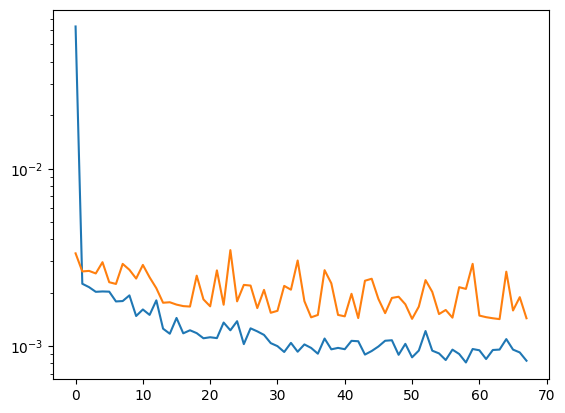

In [93]:
plt.semilogy(epoch_loss_train)
plt.semilogy(epoch_loss_val)

In [94]:
test_loader = DataLoader(list(zip(nodal_inputs_test[0:N_test],global_inputs_test[0:N_test],outputs_test[0:N_test])), 
                    batch_size=1, shuffle=False)

k=0

pred = list()
gt = list()

for nodal,scalar,targets in test_loader:
    
    print("Data point number",str(k+1))
    nodal = nodal.to(torch.float32).cuda()
    scalar = scalar.to(torch.float32).cuda()
    targets = targets.to(torch.float32).cuda()
    
    pred.append(model(nodal,scalar))
    gt.append(targets)
    
    k=k+1
    clear_output(wait=True)

Data point number 500


In [95]:
torch.stack(pred).detach().cpu().numpy().shape

(500, 1, 1)

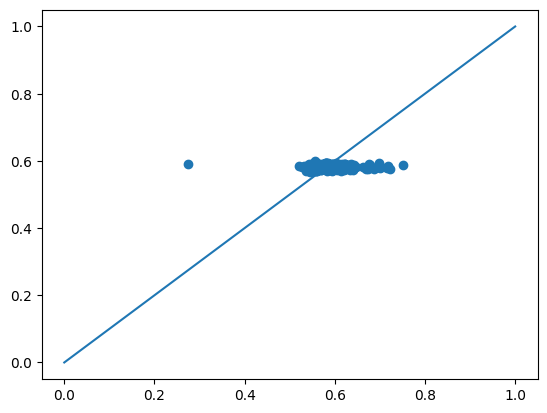

In [96]:
plt.scatter(torch.stack(gt).detach().cpu().numpy()[:,0,0,0],
           torch.stack(pred).detach().cpu().numpy()[:,0,0])
plt.plot(np.linspace(0,1,10),np.linspace(0,1,10))

In [190]:
pred

[tensor([[0.5538]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[0.5527]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[0.5457]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[0.5526]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[0.5533]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[0.5511]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[0.5528]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[0.5524]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[0.5539]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[0.5523]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[0.5511]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[0.5513]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[0.5510]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[0.5518]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[0.5515]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[0.5476]], device='cuda:0', gra